# HSE 2023: Mathematical Methods for Data Analysis

## Homework 3
## Sharapov Egor BSE219

In [1105]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from scipy.special import expit
import seaborn as sns
import sklearn
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

![LogitVsProbit.png](https://bookdown.org/mattdobra/Prelude/images/pamprobit.jpg)

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas

$$\nabla L(w) =$$
$$\sum_{i = 1}^{N} (-y_i\frac{\sigma(w^T x_i) (1 - \sigma(w^T x_i))}{\sigma(w^T x_i)} x_i \ - \ (1 - y_i) \frac{-\sigma(w^Tx_i)(1 - \sigma(w^T x_i))}{1 - \sigma(w^T x_i)}x_i) \ + \sum_{i = 1}^{K} \gamma \ sign(w_k) \ + 2 \beta w =$$
$$= \sum_{i = 1}^{N}(-y_i \ (1 - \sigma(w^Tx_i)) \ x_i + (1 - y_i) \ \sigma(w^T x_i) x_i) \ + \ \gamma \sum_{i = 1}^{K} sign(w) + 2\beta w =$$
$$= X^T (\sigma(Xw) - y) + \gamma \ sign(w) + 2\beta w$$

#### 2. [0.25 points] Implement the Elastic Net loss

Let's write regularization function:

In [742]:
def reg(w: np.array, gamma: float, beta: float) -> float:
    """
    Function that's find regularization terms.
    :param w: array of weights.
    :param gamma: gamma.
    :param beta: beta.
    :return: float.
    """
    return gamma * sum(abs(w)) + beta * sum(w**2)

For loss we need sigmoid function, let's write it:

In [743]:
def sig(w: np.array) -> float:
    """
    Function that's find sigmoid function for array.
    :param w: array of weights.
    :return: float.
    """
    return 1 / (1 + np.exp(-w))

Construct function for Elastic Net Loss:

In [744]:
def loss(X: np.array, y: np.array, w: np.array, gamma: float = 1., beta: float = 1.) -> float:
    """
    Function that's find Elastic Net loss.
    :param X: matrix.
    :param y: array.
    :param w: array of weights.
    :param gamma: gamma.
    :param beta: beta.
    :return: float.
    """
    # Set w to np.array in case that w will be List[float].
    w = np.array(w)
    return sum(-np.log(sign(np.dot(X, w.T))) * y - np.log(1 - sig(np.dot(X, w.T))) * (1 - y)) + reg(w, gamma, beta)

#### 3. [0.25 points] Implement the gradient

In [745]:
def get_grad(X: np.array, y: np.array, w: np.array, gamma: float = 1., beta: float = 1.) -> np.array:
    """
    Function that's find gradient.
    :param X: matrix.
    :param y: array.
    :param w: array of weights.
    :param gamma: gamma.
    :param beta: beta.
    :return: np.array.
    """
    # Set w to np.array in case that w will be list[float].
    w = np.array(w)
    return np.dot((sig(np.dot(X, w.T)) - y.T).T, X) + gamma * w / abs(w) + 2 * beta * w

#### Checking myself

In [746]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [747]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [952]:
def print_itaration_data(iteration: int, max_iter: int, loss: float, each_iter: int = 100) -> None:
    """
    Function that print loss every each_iter iterations.
    :param iteration: now iteration.
    :param max_iter: maximum number of iterations.
    :param loss: now loss function value.
    :param each_iter: which iteration loss should be printed.
    :return: None. 
    """
    if iteration % each_iter == 0:
        print(f"Iteration {iteration} from {max_iter}\tLoss: {loss}")
    else:
        return

In [1176]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta: float = 1.0, gamma: float = 1.0, lr: float = 1e-3, tolerance: float = 0.001,
             max_iter: int = 2000, random_state: int = 42, print_iter: bool = False) -> None:
        """
        Init function for Logit.
        :param self: self.
        :param beta: beta.
        :param gamma: gamma.
        :param lr: learning rate of function.
        :param tolerance: tolerance of model.
        :param max_iter: maximum of iterations.
        :param random_state: random state.
        :param print_iter: need to print loss while iterating.
        :return: None. 
        """
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.loss_history = []
        self.print_iter = print_iter
        self.w = None

    def fit(self, X: np.array, y: np.array) -> Logit:
        """
        Function that fit Logit.
        :param self: self.
        :param X: matrix.
        :param y: vector.
        :return: self. 
        """
        # Initialize weights from the normal distribution
        self.w = np.random.normal(size=X.shape[1])
        
        for iteration in range(self.max_iter):
            gradient = get_grad(X, y, self.w, self.gamma, self.beta)
            self.w -= self.learning_rate * gradient

            loss_step = loss(X, y, self.w, self.gamma, self.beta)
            self.loss_history.append(loss_step)

            if self.print_iter:
                print_itaration_data(iteration, self.max_iter, loss_step)
                            
            if np.linalg.norm(self.learning_rate * gradient) < self.tolerance:
                break

        return self

    def predict(self, X: np.array) -> np.array:
        """
        Function that return vector of predicted labels (0 or 1) for each object from X.
        :param X: matrix.
        :param self: self.
        :return: vector. 
        """
        predictions = self.predict_proba(X)[:,1]
        predict = np.ones(predictions.shape[0])
        predict[predictions < 0.5] = 0

        return predict

    def predict_proba(self, X: np.array) -> np.array:
        """
        Function that return vector of probabilities for each object from X
        :param self: self.
        :param X: matrix.
        :return: np.array. 
        """
        data = [sig(np.dot(X, self.w)), sig(-np.dot(X, self.w))]
        return np.transpose(np.array(data))
        # return sig(np.dot(X, self.w))

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'gamma': self.gamma,
            'lr': self.learning_rate,
            'tolerance': self.tolerance,
            'max_iter': self.max_iter,
            'random_state': self.random_state,
            'print_iter': self.print_iter
        }

Let's get sample data to test our model

In [1150]:
from sklearn.datasets import make_classification

In [1151]:
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

We need function to plot boundary

In [1152]:
def plot_decision_boundary(model, X, y):
    """
    Function that plot the decision boundary.
    :param model: a Logit model.
    :param X: matrix.
    :param y: vector.
    :return: None. 
    """
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

Create model

Iteration 0 from 2000	Loss: 354.7325415522818
Iteration 100 from 2000	Loss: 45.67614474628467
Iteration 200 from 2000	Loss: 42.08066233880125
Iteration 300 from 2000	Loss: 41.34788951726815
Iteration 400 from 2000	Loss: 41.12432186302388


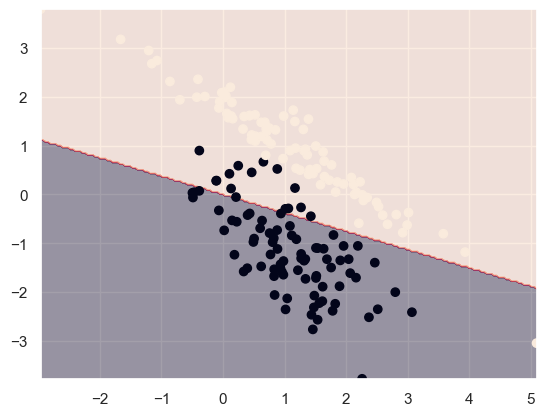

In [1166]:
model = Logit(0, 0, print_iter=True)
model.fit(X, y)
# Create plot.
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

In [1154]:
# Hide warnings.
import warnings
warnings.filterwarnings("ignore")

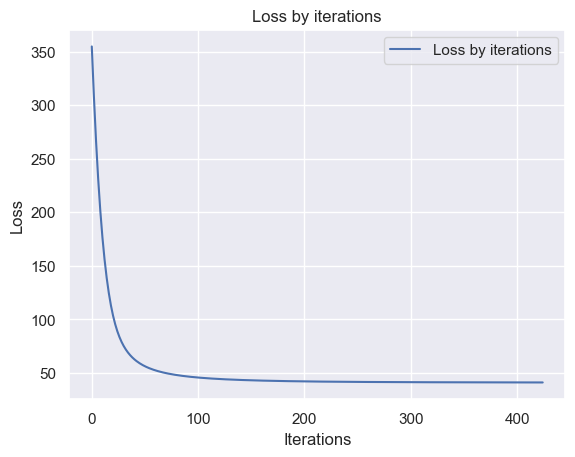

In [1167]:
sns.lineplot(data = model.loss_history, label="Loss by iterations")
plt.title("Loss by iterations")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

## PART 2: Support Vector Machines

![svm.png](https://ih1.redbubble.net/image.486010790.3726/st,small,507x507-pad,600x600,f8f8f8.u2.jpg)

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

Let's get metrics for kernels

In [298]:
from sklearn.metrics import *

Now lets create function for getting info about model and print metrics

In [322]:
def get_info(X: np.array, y: np.array, model, model_name: str = "None", need_print: bool = False) -> dict():
    """
    Function that returns metrics and print if needed.
    :param X: matrix.
    :param y: vector.
    :param model: model.
    :param model_name: name of model.
    :param need_print: is print of metrics needed.
    :return: dict[str, float]. 
    """
    metrics = {}
    
    metrics["accuracy"] = sklearn.metrics.accuracy_score(y_true=y, y_pred=model.predict(X))
    metrics["roc_auc"] = sklearn.metrics.roc_auc_score(y_true=y, y_score= model.predict_proba(X)[:, 1])
    metrics["f1_score"] = sklearn.metrics.f1_score(y_true=y, y_pred=model.predict(X))
    
    if need_print:
        print(f'Model: {model_name}| accuracy: {metrics["accuracy"]}\troc_auc: {metrics["roc_auc"]}\tf1_score: {metrics["f1_score"]}')

    return metrics

### Linear

Let's take care of Linear SVM by using it!

For further work we need some imports:

In [300]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

Now let's create function for creation metrics plots.

In [323]:
def create_plot(data: dict(), param_name: str = "None", model_name: str = "None") -> None:
    """
    Function that represents metrics and creates plots.
    :param data: dict with data about metrics.
    :param param_name: name of parameter.
    :param model_name: name of model.
    :return: None. 
    """
    plt.figure(figsize=(20, 8))
    sns.lineplot(x=data.keys(), y=[metrics['accuracy'] for metrics in data.values()])
    plt.title(f"Model {model_name} | Accuracy by {param_name}")
    plt.ylabel("Accuracy")
    plt.xlabel(param_name)
    plt.show

    plt.figure(figsize=(20, 8))
    sns.lineplot(x=data.keys(), y=[metrics['roc_auc'] for metrics in data.values()])
    plt.title(f"{model_name} | ROC AUC by {param_name}")
    plt.ylabel("ROC AUC")
    plt.xlabel(param_name)
    plt.show

    plt.figure(figsize=(20, 8))
    sns.lineplot(x=data.keys(), y=[metrics['f1_score'] for metrics in data.values()])
    plt.title(f"{model_name} | F1 score by {param_name}")
    plt.ylabel("F1 score")
    plt.xlabel(param_name)
    plt.show

Now we need to change our Regularization parameter for Linear SVM

In [327]:
reg_param = np.logspace(-2, 0, 30)

Lets accumulate our data and create plots

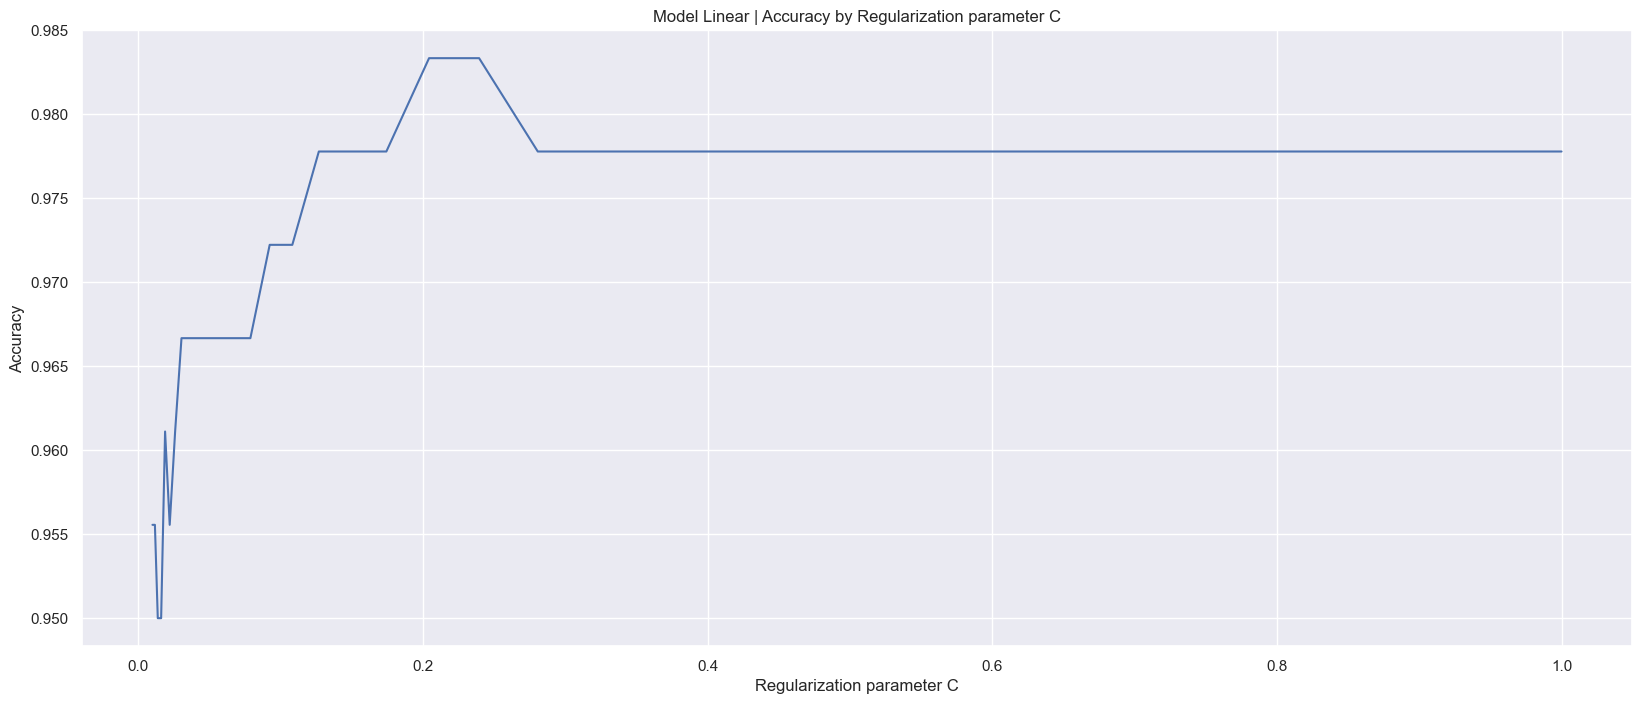

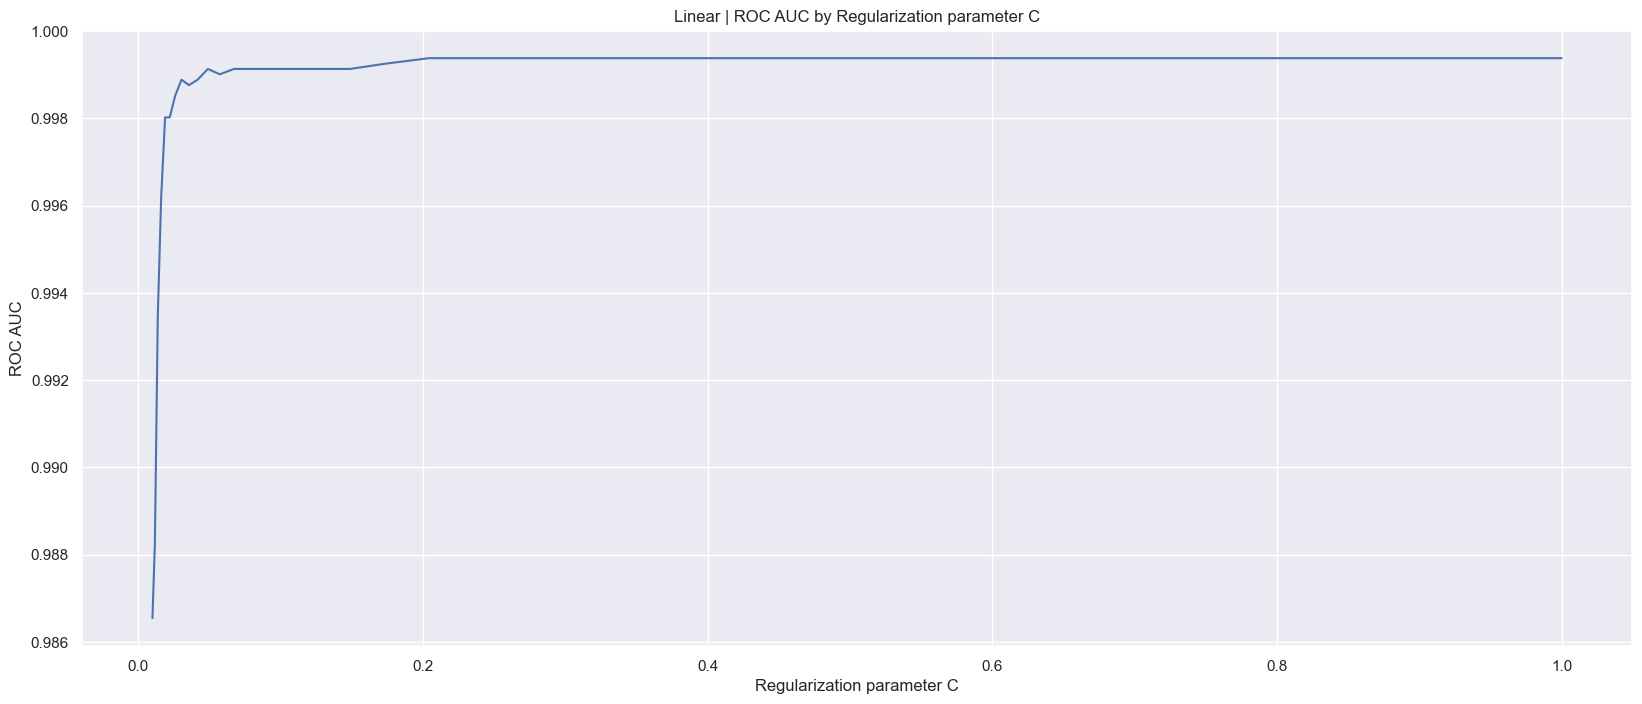

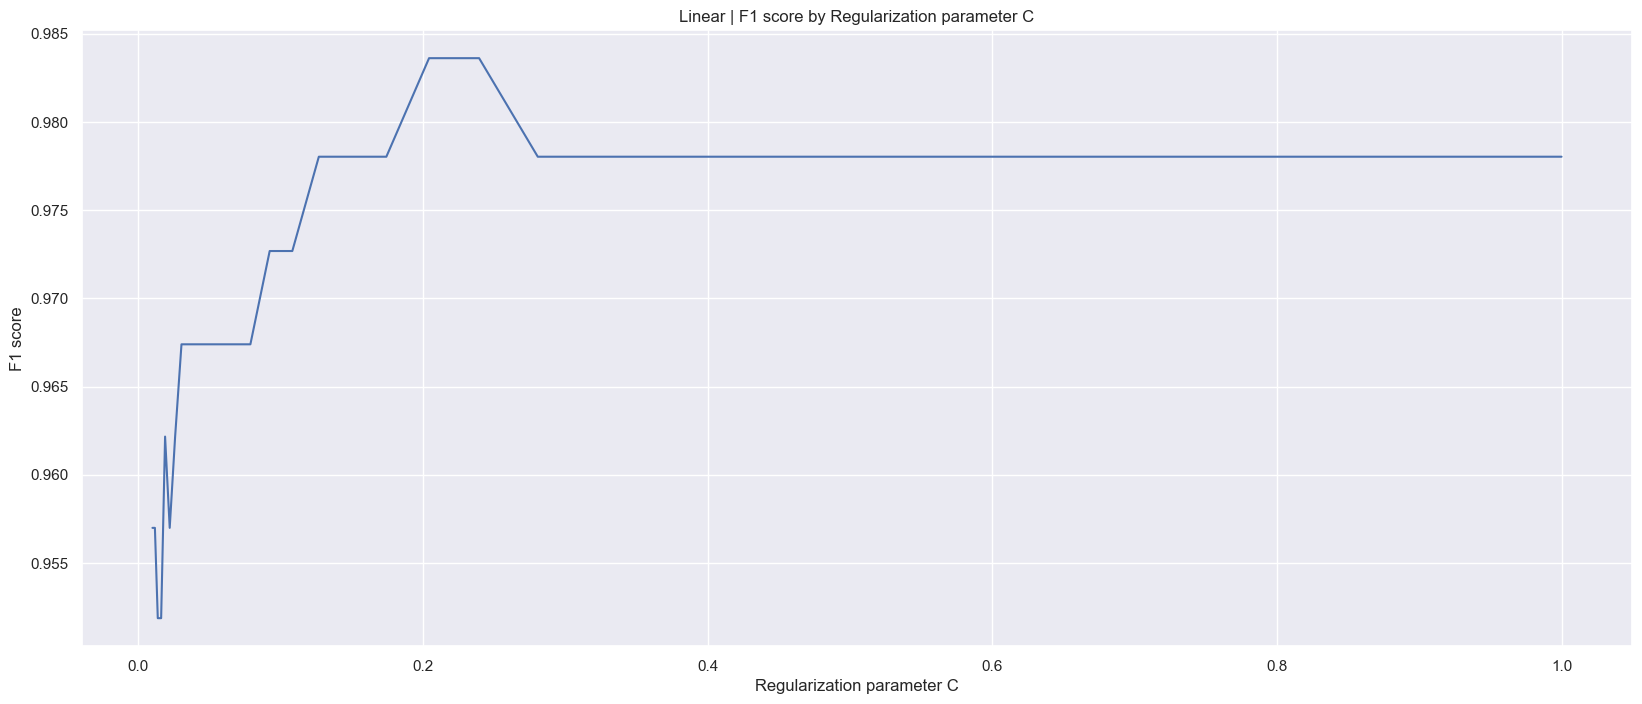

In [330]:
linear_data = {}
for param in reg_param:
    linear = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True, C=param))
    linear.fit(X, y)
    linear_data[param] = get_info(X, y, linear)

create_plot(linear_data, "Regularization parameter C", "Linear")

### Polynomial

Let's create parametrs for degree.

In [331]:
degree_param = [2, 3, 4, 5]

Lets accumulate our data and create plots

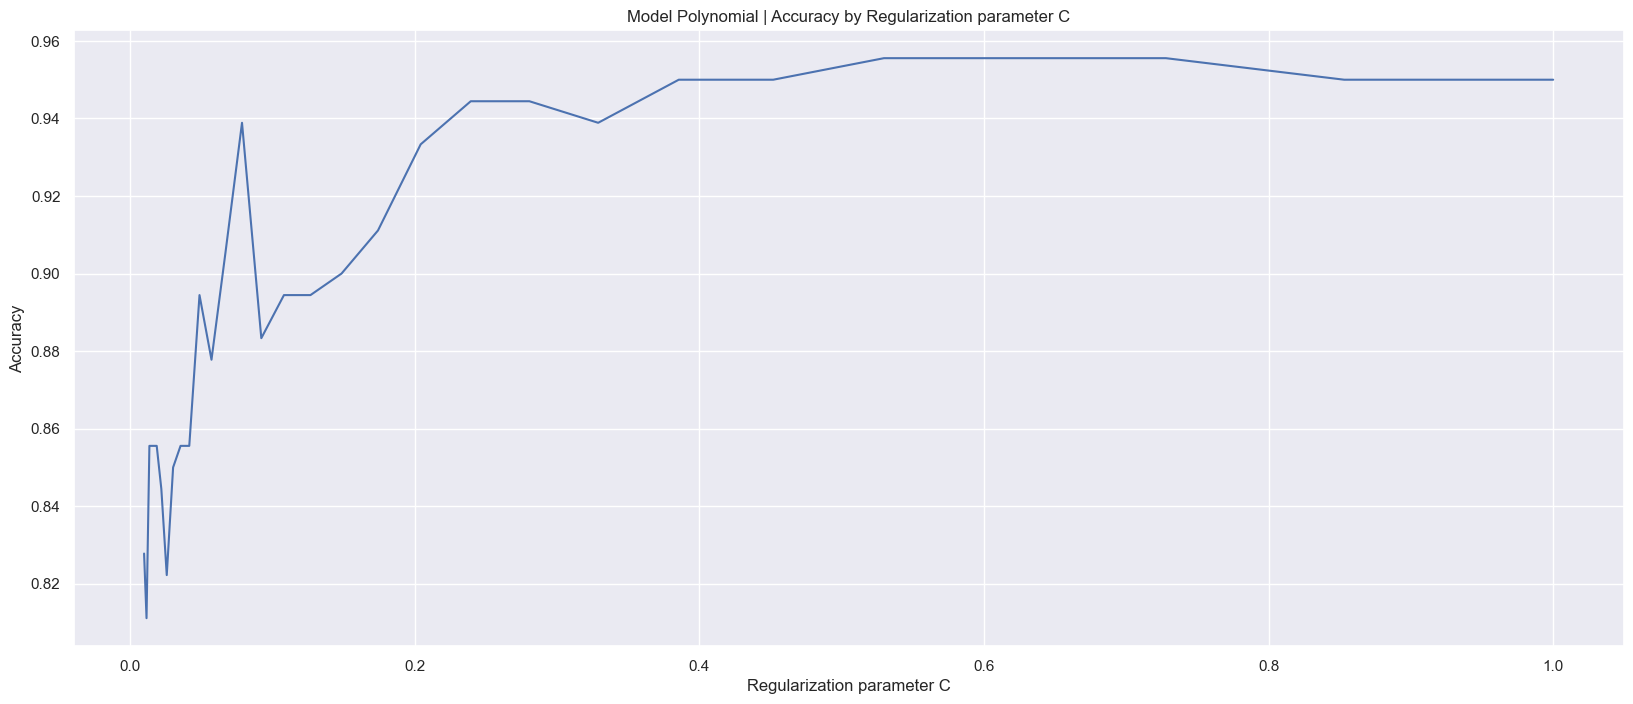

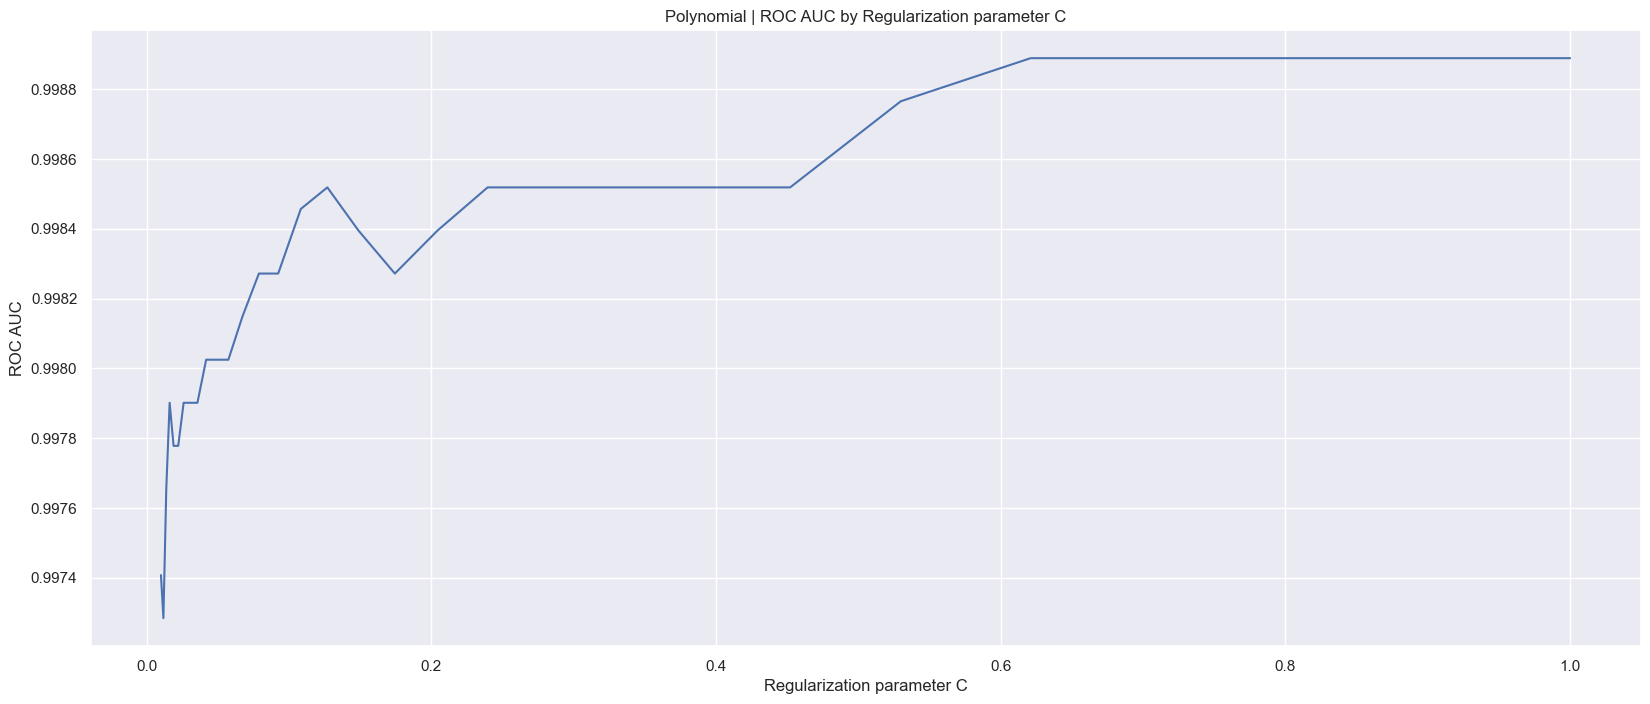

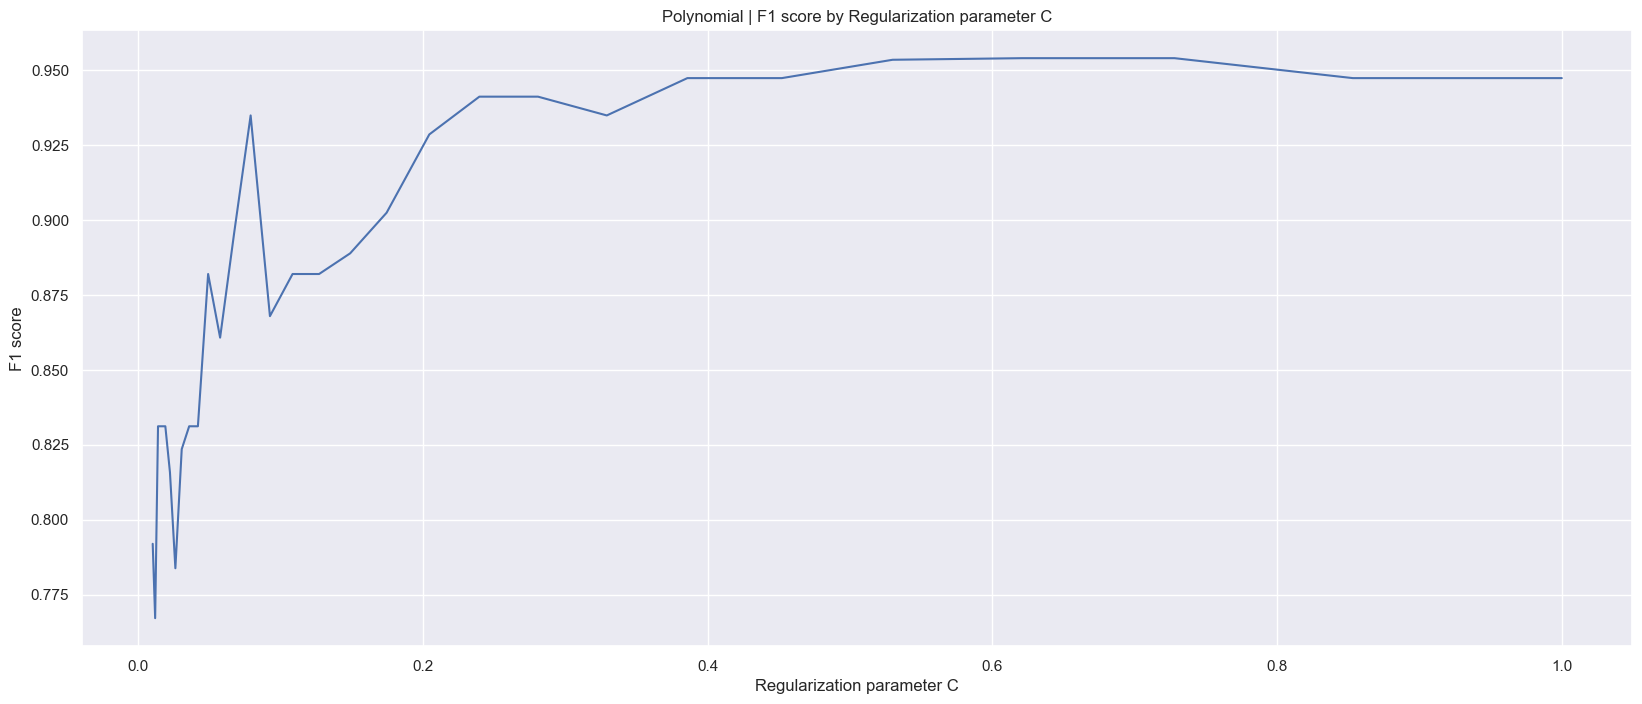

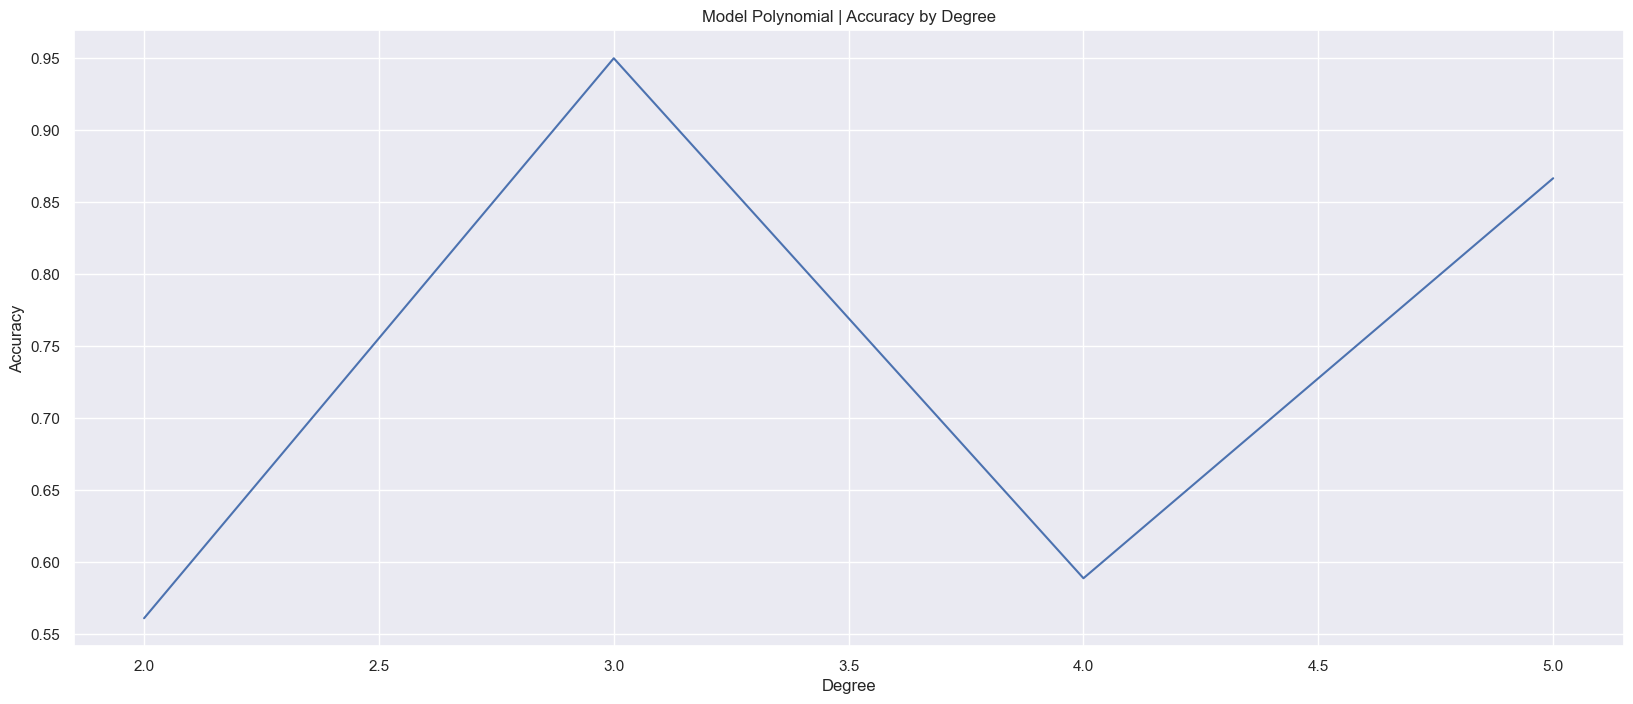

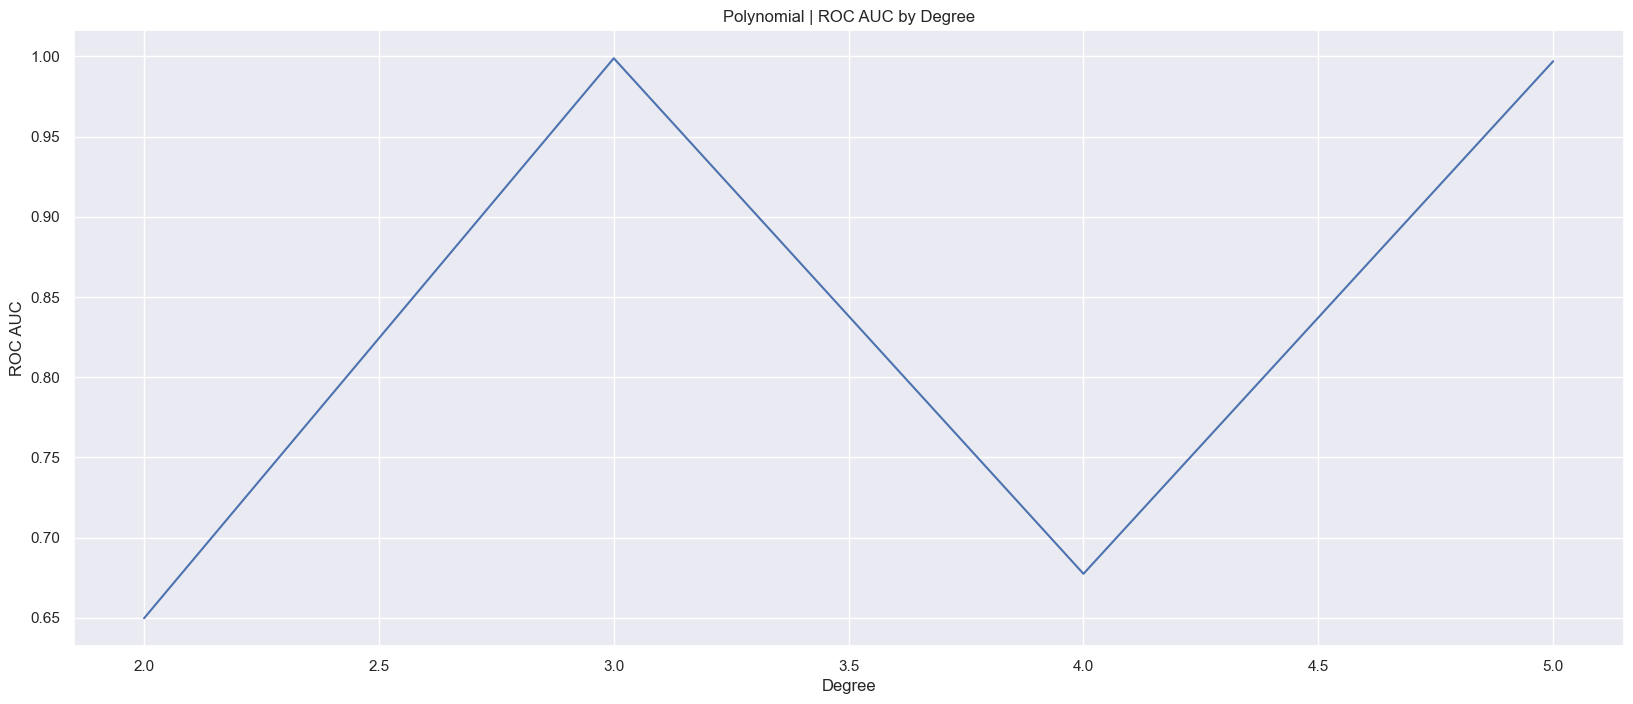

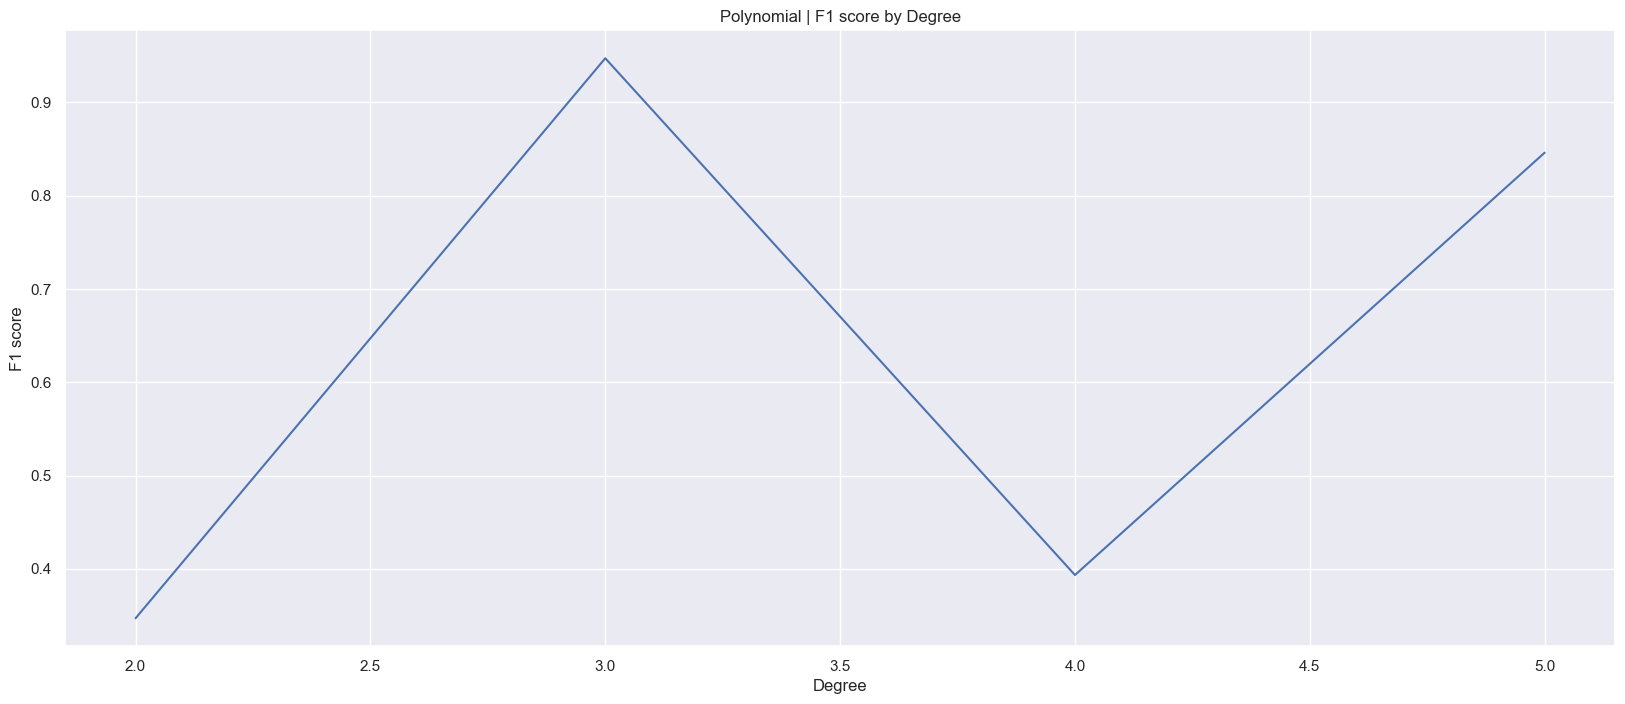

In [352]:
polynomial_data = {}

for param in reg_param:
    poly = make_pipeline(StandardScaler(), SVC(kernel='poly', probability=True, C=param))
    poly.fit(X, y)
    polynomial_data[param] = get_info(X, y, poly)

create_plot(polynomial_data, "Regularization parameter C", "Polynomial")

polynomial_data_degree = {}

for degree in degree_param:
    poly = make_pipeline(StandardScaler(), SVC(kernel='poly', probability=True, degree=degree))
    poly.fit(X, y)
    polynomial_data_degree[degree] = get_info(X, y, poly)

create_plot(polynomial_data_degree, "Degree", "Polynomial")

### RBF

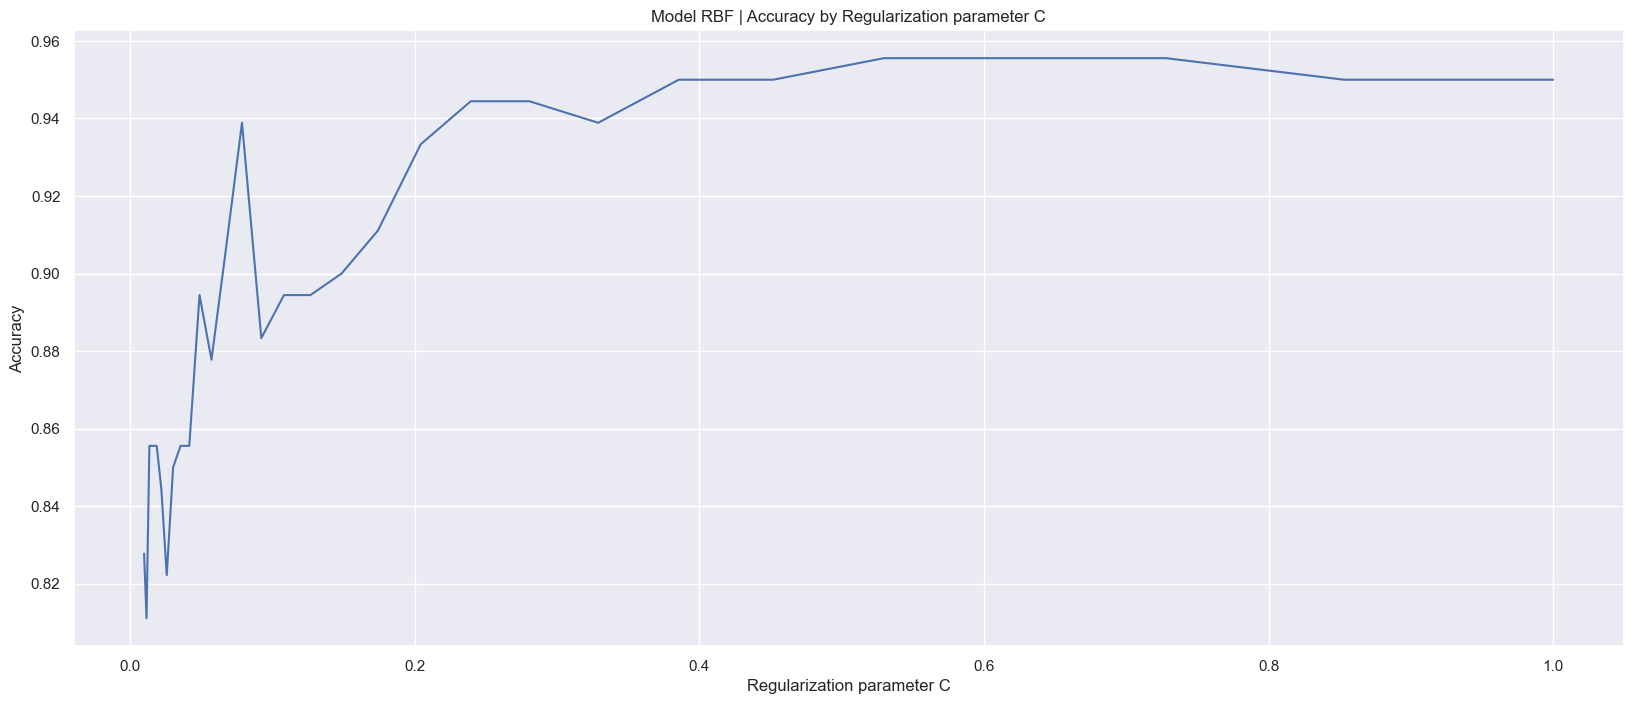

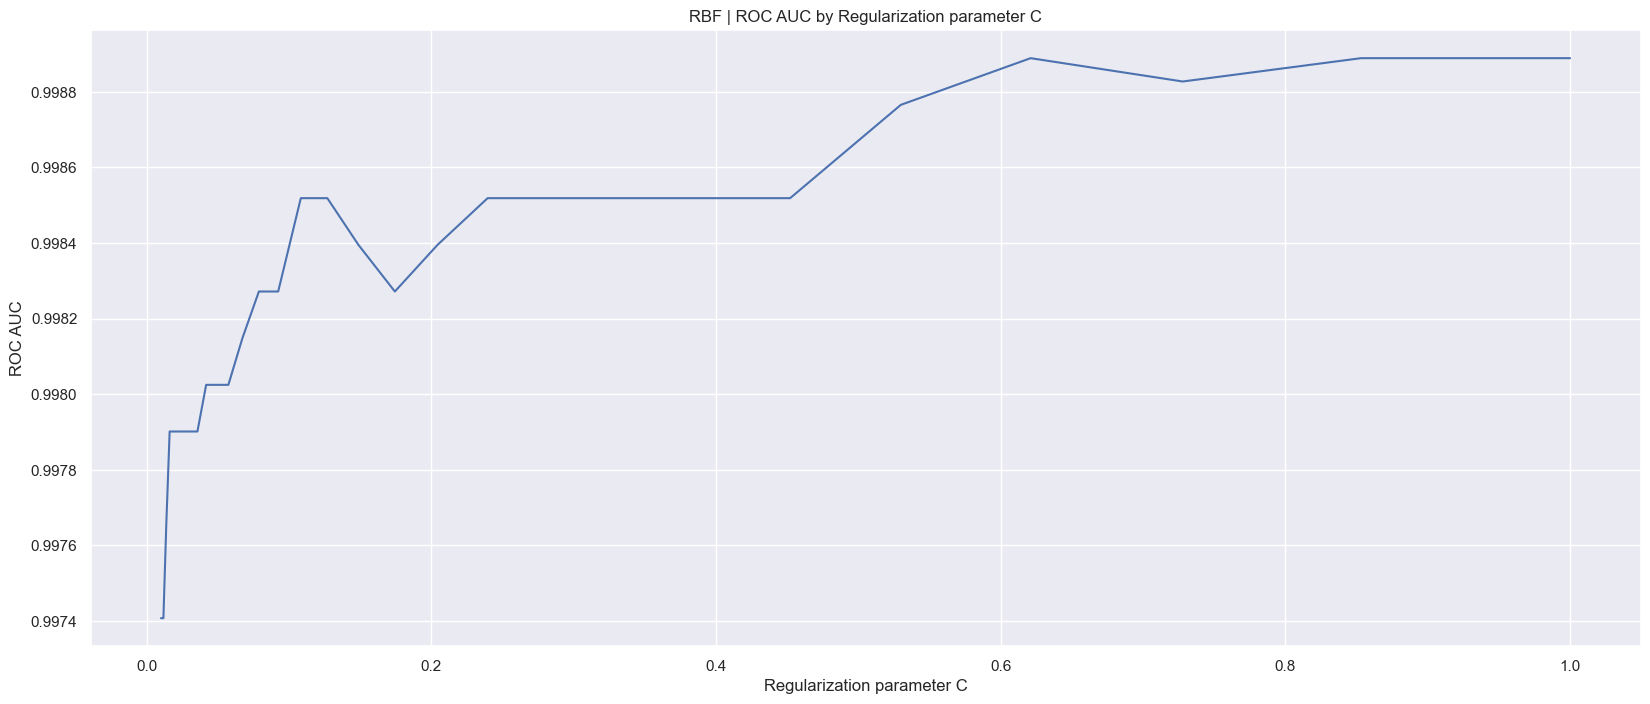

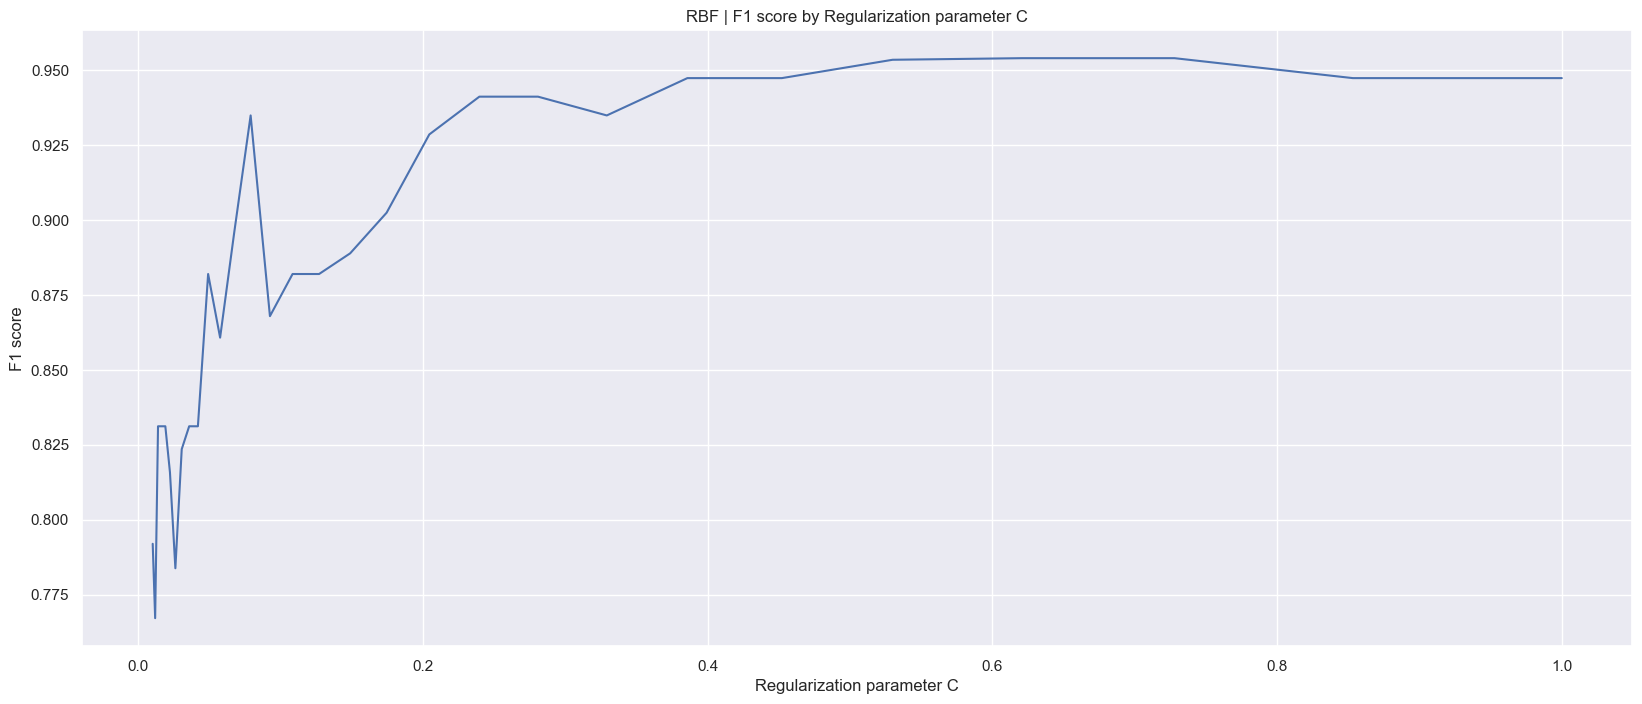

In [344]:
rbf_data = {}

for param in reg_param:
    rbf = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, C=param))
    rbf.fit(X, y)
    rbf_data[param] = get_info(X, y, rbf)

create_plot(polynomial_data, "Regularization parameter C", "RBF")

### Compare

In [349]:
def create_plot_compare(data: dict(), param_name: str = "None") -> None:
    """
    Function that represents metrics and creates plots.
    :param data: dict with data about metrics.
    :param param_name: name of parameter.
    :return: None. 
    """
    plt.figure(figsize=(20, 8))
    sns.lineplot(x=data["Linear"].keys(), y=[metrics['accuracy'] for metrics in data["Linear"].values()], label = "Linear")
    sns.lineplot(x=data["Poly"].keys(), y=[metrics['accuracy'] for metrics in data["Poly"].values()], label = "Poly")
    sns.lineplot(x=data["RBF"].keys(), y=[metrics['accuracy'] for metrics in data["RBF"].values()], label = "RBF")
    plt.title(f"Accuracy by {param_name}")
    plt.ylabel("Accuracy")
    plt.xlabel(param_name)
    plt.show

    plt.figure(figsize=(20, 8))
    sns.lineplot(x=data["Linear"].keys(), y=[metrics['roc_auc'] for metrics in data["Linear"].values()], label = "Linear")
    sns.lineplot(x=data["Poly"].keys(), y=[metrics['roc_auc'] for metrics in data["Poly"].values()], label = "Poly")
    sns.lineplot(x=data["RBF"].keys(), y=[metrics['roc_auc'] for metrics in data["RBF"].values()], label = "RBF")
    plt.title(f"ROC AUC by {param_name}")
    plt.ylabel("ROC AUC")
    plt.xlabel(param_name)
    plt.show

    plt.figure(figsize=(20, 8))
    sns.lineplot(x=data["Linear"].keys(), y=[metrics['f1_score'] for metrics in data["Linear"].values()], label = "Linear")
    sns.lineplot(x=data["Poly"].keys(), y=[metrics['f1_score'] for metrics in data["Poly"].values()], label = "Poly")
    sns.lineplot(x=data["RBF"].keys(), y=[metrics['f1_score'] for metrics in data["RBF"].values()], label = "RBF")
    plt.title(f"F1 score by {param_name}")
    plt.ylabel("F1 score")
    plt.xlabel(param_name)
    plt.show

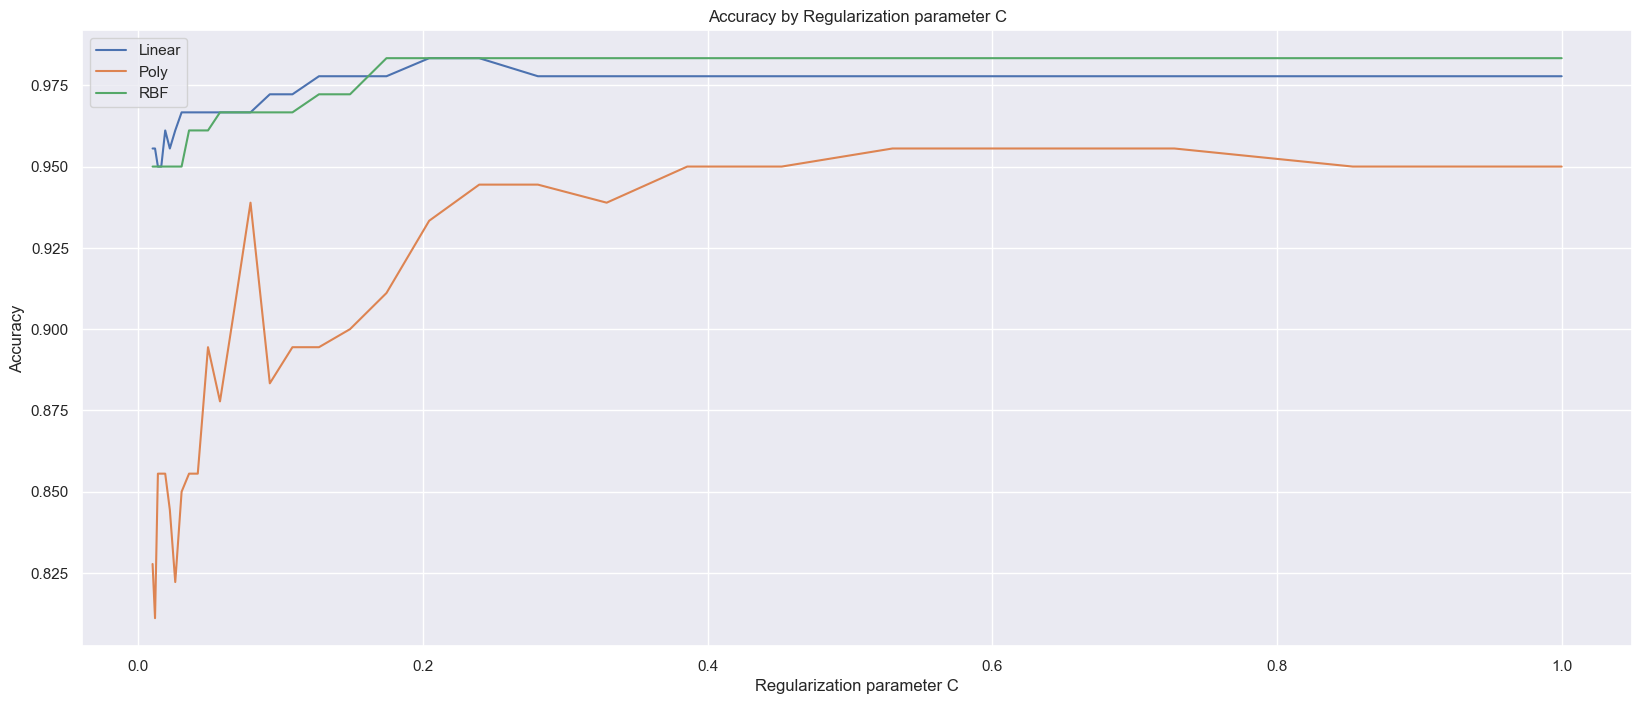

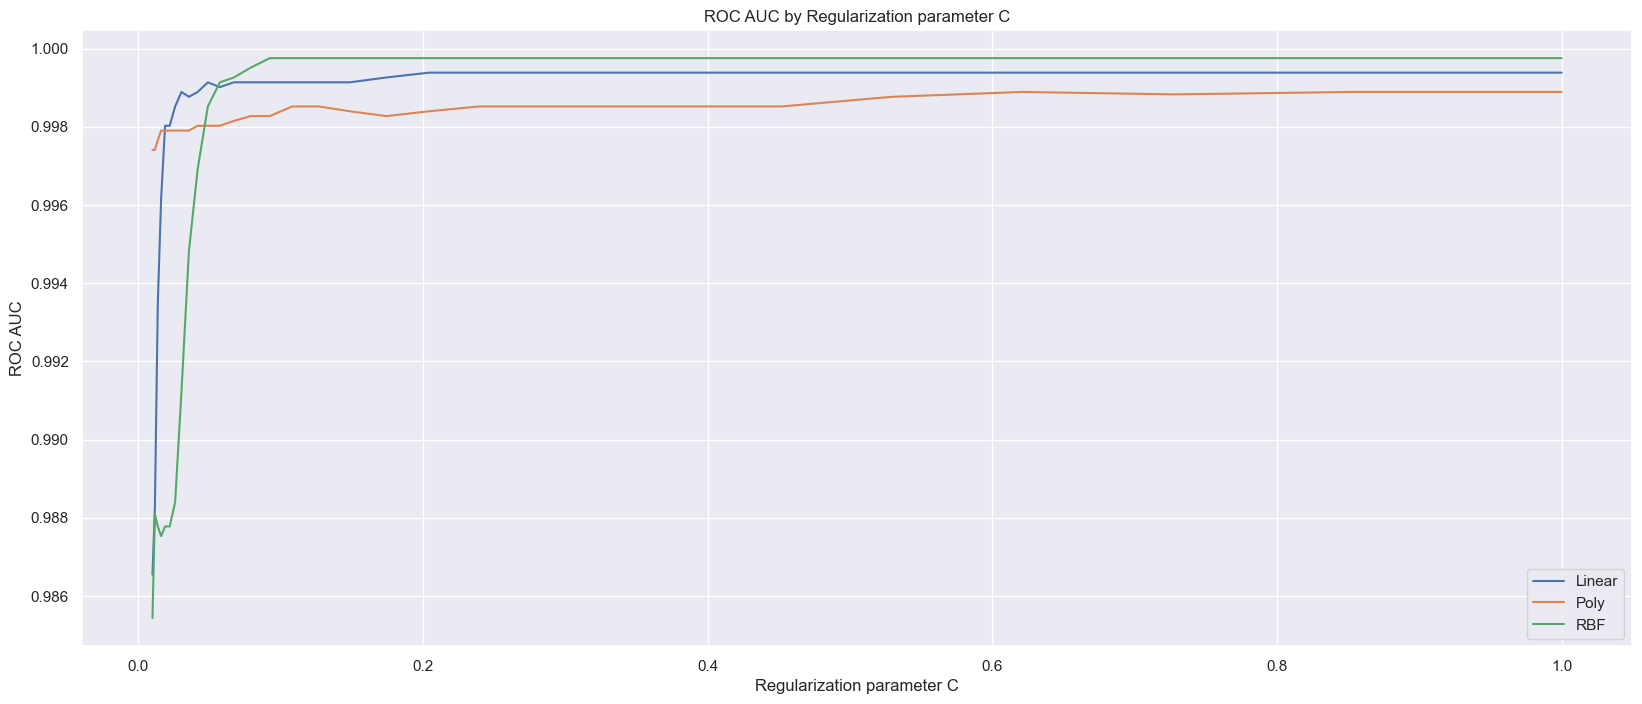

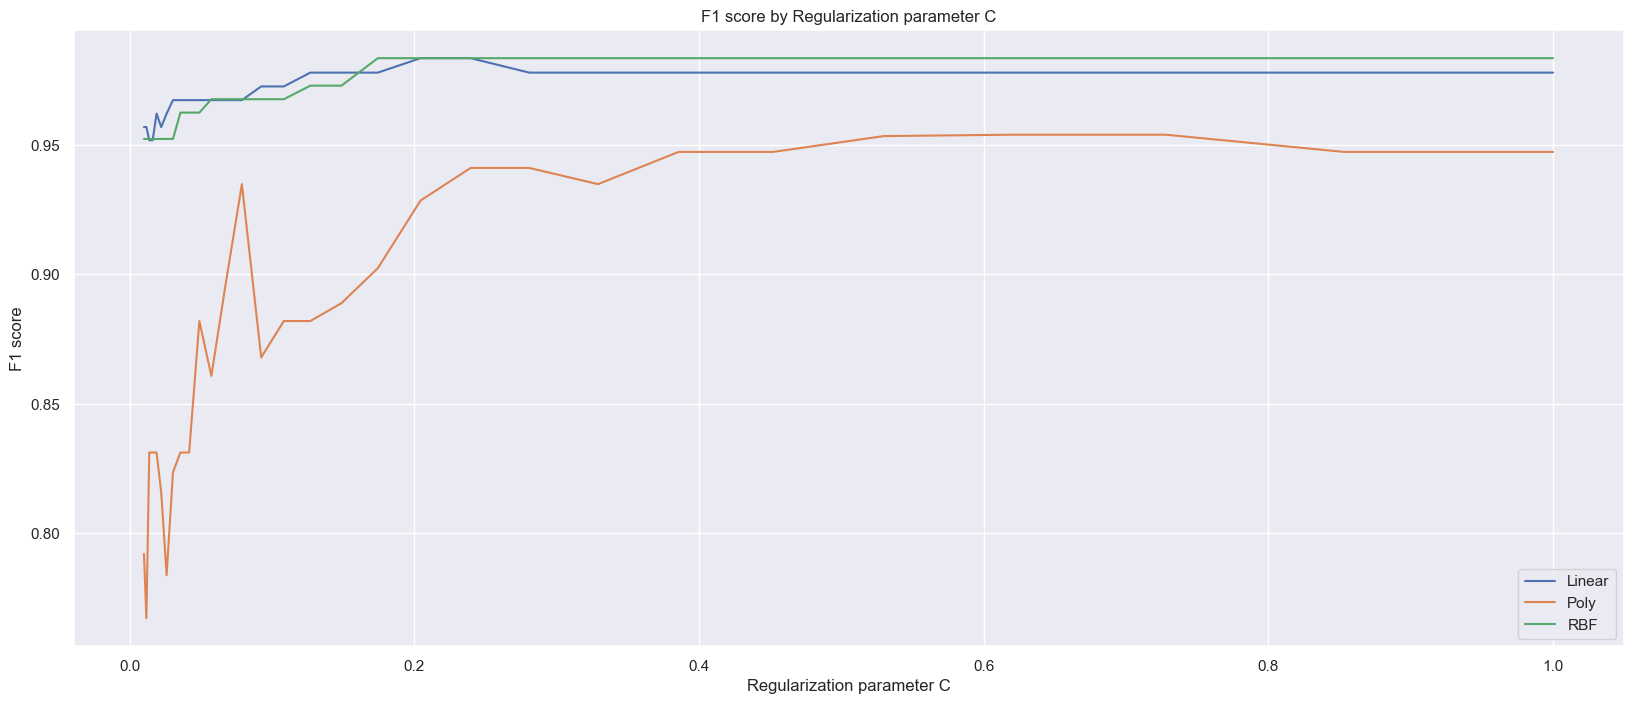

In [351]:
# Lets acumulate data for our kernels

models = {"Linear": linear_data,
          "Poly": polynomial_data,
          "RBF": rbf_data}

create_plot_compare(models, "Regularization parameter C")

### Conclusion

The **RBF kernel** performs the best on all three quality metrics, while **Polynomial** performs the worst **(best metrics for 3 degree Polynomial)**, which is directly related to hyperparameter fitting. 

**Linear kernel** is less prone to overfitting, while **RBF kernel** is more flexible but require careful hyperparameter tuning to prevent overfitting. **Polynomial kernel** offer a middle ground. 

Regularization, controlled by the *C* parameter, is essential for preventing overfitting in all kernels, but it's more critical for non-linear kernels like **RBF** and **Polynomial kernel**.

## PART 3: Natural Language Processing

![img.png](https://preview.redd.it/h32sempct2r51.jpg?width=640&crop=smart&auto=webp&s=116b2958975eb8864fe887f9c792a6e24d209c5b)

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

#### 0. Choose six authors

Importing os module

In [366]:
import os 

Set path to data directory

In [367]:
path = "./prose"

Take directories of my 6 favorite authors: **Blok, Dostoevsky, Gogol, Gorky, Lermontov and Turgenev**.

In [369]:
authors = os.listdir(path)
authors

['Blok', 'Dostoevsky', 'Gogol', 'Gorky', 'Lermontov', 'Turgenev']

In [443]:
authors_names_in_russian = {'Blok': 'Блок','Dostoevsky': 'Достоевский', 'Gogol': 'Гоголь', 'Gorky': 'Горький', 'Lermontov': 'Лермонтов', 'Turgenev': 'Тургенев'}

#### 1. Build your own dataset for authors

Let's import needed libraries

In [441]:
import string
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Create dict for raw data:

In [382]:
raw = {}

Next we need to add data to our raw dataset

In [424]:
# For author.
for author in authors:
    # Create list for sentences.
    sentences = list()
    # Get texts of now author.
    texts = os.listdir(os.path.join(path, author))

    # For each file in author directory.
    for text in texts:
        with open(os.path.join(path, author, text), encoding='utf-8') as file:
            # Let's get extencion of each file.
            file_name, file_extension = os.path.splitext(os.path.join(path, author, text))
            # Only if extenxion is .txt and sentence is 15 or more in size we can add it in sentences.
            if file_extension == '.txt':
                data = nltk.tokenize.sent_tokenize(file.read()) 
                for sentence in data:
                    if len(sentence) < 15:
                        continue
                    sentences.append(sentence)
                    
    raw[author] = sentences

Now we neeed to find lens of all groups by authors:

In [425]:
raw_sizes = {}

In [426]:
for author, sentences in raw.items():
    raw_sizes[author] = len(sentences)

Sort authors in ascending style

In [427]:
raw_sizes = dict(sorted(raw_sizes.items(), key=lambda item: item[1]))

Lets fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively

In [428]:
proportion = [3, 5, 8, 11, 15, 20]

i = 0
for author in raw_sizes.keys():
    raw_sizes[author] = raw_sizes[author] / proportion[i]
    i += 1

Let's go randomly choose sentences

In [444]:
selected_sentences = {}

i = 0
for author in raw.keys():
    selected_sentences[authors_names_in_russian[author]] = [] 
    
    for sentence in np.random.choice(raw[author], replace=False, size=(int(math.floor(min(raw_sizes.values())))) * proportion[i]):
       selected_sentences[authors_names_in_russian[author]].append(sentence)
        
    i += 1

Let's already form our dataset

In [445]:
dataset =  pd.DataFrame([(sentence, author) for author, sentences in selected_sentences.items() for sentence in sentences], columns=['sentence', 'author'])
dataset

,sentence,author
0,В щель калитки просунулась бумажка.,Блок
1,"Без усилия полился и сразу наполнил и овраг, и...",Блок
2,"- Так, значит, буржуев резать будут?",Блок
3,что могло стать великим счастьем.,Блок
4,"Как упорно ищет, и сколько столетий, а все еще...",Блок
...,...,...
8675,Притом – странное дело!,Тургенев
8676,"– Вы бы опять спел сфой романце лутчи, – возра...",Тургенев
8677,"– твердил он медленно и злобно, широко разевая...",Тургенев
8678,"– Я здесь, – отвечал он, – я приду, ступай.",Тургенев


#### 2. Preprocess (tokenize and clean) the dataset

Let's remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers

We need to import some tools:

In [1065]:
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [459]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's create function for preprocess sentences.

In [556]:
def preprocess_text(text: str) -> str:
    """
    Function that preproces sentences and return them.
    :param text: a sentence that we need to preprocess.
    :return: str. 
    """
    # Tokenization!
    tokens = word_tokenize(text)
    
    # Remove stopwords, punctuation, and numbers.
    tokens = [word.lower() for word in tokens if (word.isalpha() and word.lower() not in stop_words)]
    
    # Stemming!
    stemmer = SnowballStemmer("russian")
    tokens = [stemmer.stem(word) for word in tokens]
    
    return " ".join(tokens)

Now let's add preprocesed sentences in our dataset!

In [461]:
dataset['processed_sentence'] = dataset['sentence'].apply(preprocess_text)

In [721]:
label_encoder = LabelEncoder()
dataset['author_label'] = label_encoder.fit_transform(dataset['author'])
dataset

,sentence,author,processed_sentence,author_label
0,В щель калитки просунулась бумажка.,Блок,щел калитк просунул бумажк,0
1,"Без усилия полился и сразу наполнил и овраг, и...",Блок,усил пол сраз наполн овраг рощ сад сильн сереб...,0
2,"- Так, значит, буржуев резать будут?",Блок,знач буржу реза будут,0
3,что могло стать великим счастьем.,Блок,могл стат велик счаст,0
4,"Как упорно ищет, и сколько столетий, а все еще...",Блок,упорн ищет скольк столет молод,0
...,...,...,...,...
8675,Притом – странное дело!,Тургенев,прит стран дел,5
8676,"– Вы бы опять спел сфой романце лутчи, – возра...",Тургенев,спел сфо романц лутч возраз лемм отвод рук пан...,5
8677,"– твердил он медленно и злобно, широко разевая...",Тургенев,тверд медлен злобн широк разев сво волч рот,5
8678,"– Я здесь, – отвечал он, – я приду, ступай.",Тургенев,отвеча прид ступа,5


Next vectorize words using both bag of words and tf-idf!

In [722]:
count_vectorizer = CountVectorizer(max_features=1000)
bag = count_vectorizer.fit_transform(dataset['processed_sentence'])

In [723]:
words = list(count_vectorizer.vocabulary_.keys())
words.sort()
dataset_bag = pd.DataFrame(bag.toarray(), columns=words)
dataset_bag['author'] = dataset['author']

Next:

In [724]:
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(bag)
dataset_tfidf = pd.DataFrame(tfidf.toarray(), columns=words)
dataset_tfidf['author'] = dataset['author']

In [725]:
print("Bag of Words")
dataset_bag

Bag of Words


,азамат,ал,александрович,алеш,ан,аркад,ах,баб,бабушк,базар,...,шут,щек,эк,эт,яв,явля,язык,ярк,ясн,author
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Блок
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Блок
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Блок
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Блок
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Блок
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Тургенев
8676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Тургенев
8677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Тургенев
8678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Тургенев


In [726]:
print("TF-IDF")
dataset_tfidf

TF-IDF


,азамат,ал,александрович,алеш,ан,аркад,ах,баб,бабушк,базар,...,шут,щек,эк,эт,яв,явля,язык,ярк,ясн,author
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Блок
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Блок
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Блок
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Блок
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Блок
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев
8676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев
8677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев
8678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев


observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


Let's import some tools that we need.

In [898]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score

Let's choose two authors for binary classification.

In [969]:
author1 = 'Лермонтов'
author2 = 'Тургенев'

# Let's select data for the chosen authors!
binary_dataset = pd.concat([dataset_tfidf[dataset_tfidf.author == author1].sample(n = 2_100, random_state=42),
                            dataset_tfidf[dataset_tfidf.author == author2].sample(n = 2_100, random_state=42)],
                           ignore_index=True)

Let's check the balance of classes

In [970]:
print(f"Class balance: {binary_dataset['author'].value_counts()}")

Class balance: author
Лермонтов    2100
Тургенев     2100
Name: count, dtype: int64


In [971]:
binary_dataset

,азамат,ал,александрович,алеш,ан,аркад,ах,баб,бабушк,базар,...,шут,щек,эк,эт,яв,явля,язык,ярк,ясн,author
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Лермонтов
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Лермонтов
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Лермонтов
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Лермонтов
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Лермонтов
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев
4196,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев
4197,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев
4198,0.0,0.0,0.0,0.0,0.0,0.761199,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев


Now let's add Lable encoder for authors.

In [972]:
label_encoder = LabelEncoder()
binary_dataset['author_label'] = label_encoder.fit_transform(binary_dataset['author'])

In [973]:
binary_dataset

,азамат,ал,александрович,алеш,ан,аркад,ах,баб,бабушк,базар,...,щек,эк,эт,яв,явля,язык,ярк,ясн,author,author_label
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Лермонтов,0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Лермонтов,0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Лермонтов,0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Лермонтов,0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Лермонтов,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев,1
4196,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев,1
4197,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев,1
4198,0.0,0.0,0.0,0.0,0.0,0.761199,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев,1


Let's Divide the data into train and test samples

In [978]:
X = binary_dataset.drop(['author', 'author_label'], axis=1)
y = binary_dataset['author_label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

Making grid search for Logit model.

In [1169]:
logit_params = {
    'beta': [0, 0.001, 0.01, 1],
    'gamma': [1, 0.001, 0.01],
    'lr': [0.001, 0.01]
}

logistic_grid = GridSearchCV(Logit(), logit_params, cv=5, scoring='f1', n_jobs=-1)
logistic_grid.fit(X_train, y_train)
print('Best params: ', logistic_grid.best_params_)

Best params:  {'beta': 0, 'gamma': 1, 'lr': 0.001}


Making grid search for SVC model.

In [1021]:
svc_params = {
    'C': [0.001, 0.01, 0.1, 10],
    'gamma': ['scale', 'auto', 1],
    'kernel': ['linear', 'rbf']
}
svc_grid = GridSearchCV(SVC(probability=True), svc_params, cv=5, scoring='f1', n_jobs=-1)
svc_grid.fit(X_train, y_train)
print('Best params: ', svc_grid.best_params_)

Best params:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


Now let's create function for showing all plots.

In [1238]:
def plot_f1_vs_params(model_name: str, grid_results: dict()) -> None:
    """
    Function that construct plot based on grid results and model name.
    :param model_name: name of model.
    :param text: grid results afte grid search.
    :return: None. 
    """
    data = []
    if model_name == 'Logistic Regression':
        for i in [str(params) for params in grid_results['params']]:
            data.append(0.1)
    else:
        data = grid_results['mean_test_score']
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=[str(params) for params in grid_results['params']],
                 y=data)
    plt.title(f'Model: {model_name} | F1 Score by parameters')
    plt.xlabel('Parameters')
    plt.ylabel('F1 score')
    plt.xticks(rotation=45)
    plt.show()


Let's consstruct plots

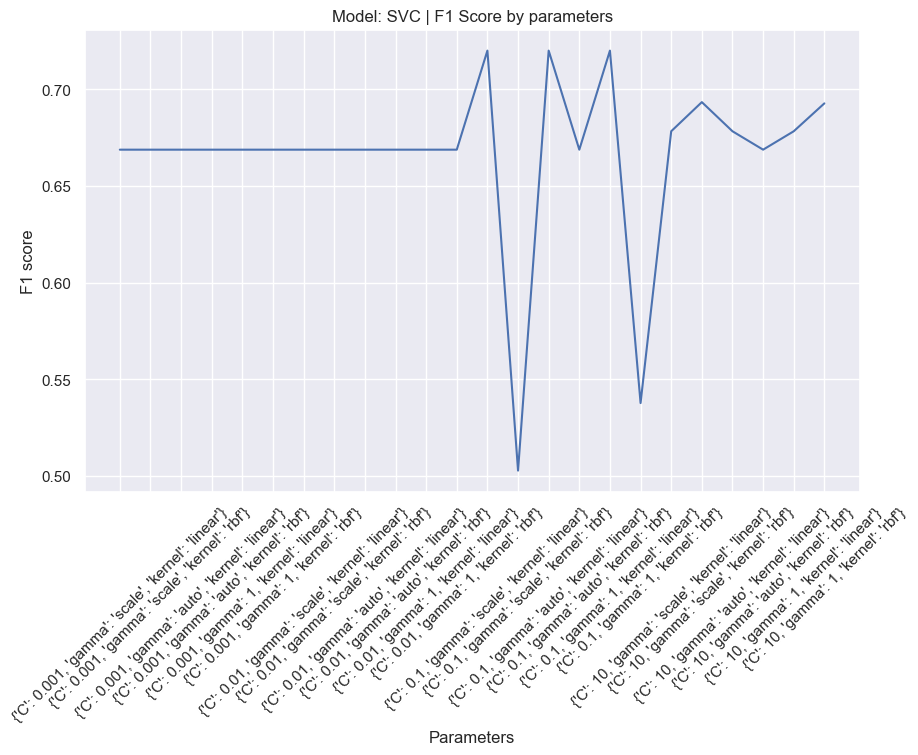

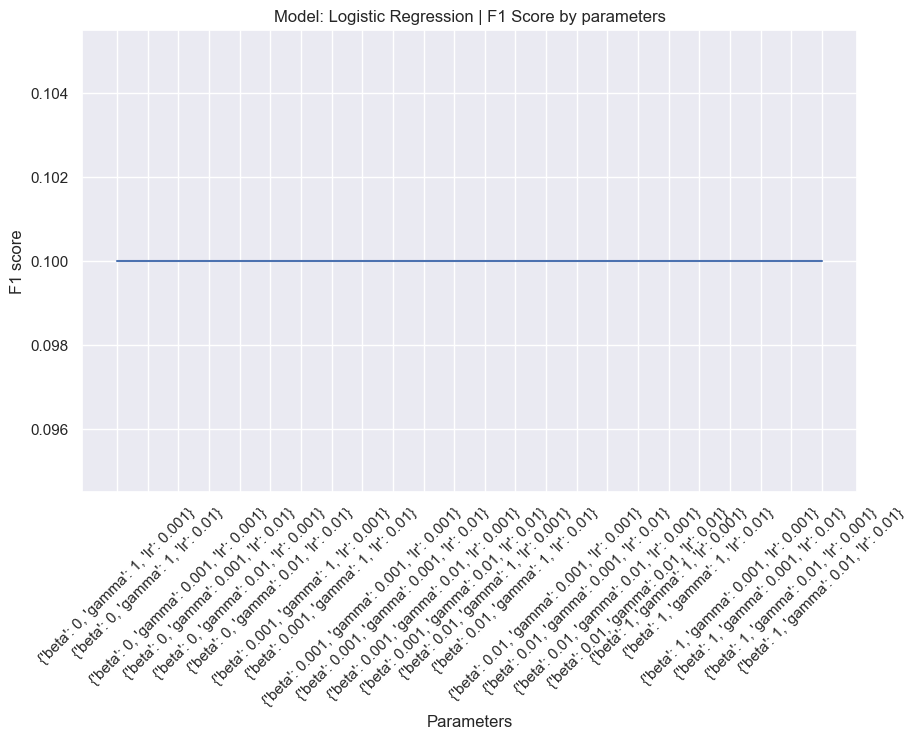

In [1239]:
plot_f1_vs_params('SVC', svc_grid.cv_results_)
plot_f1_vs_params('Logistic Regression', logistic_grid.cv_results_)

Let's evaluate on the test and train set.

In [1173]:
logistic_predictions_train = logistic_grid.predict(X_train)
svc_predictions_train = svc_grid.predict(X_train)

logistic_predictions_test = logistic_grid.predict(X_test)
svc_predictions_test = svc_grid.predict(X_test)

Creating function for construct heatmap.

In [1162]:
from sklearn.metrics import ConfusionMatrixDisplay

In [1163]:
def confusion_matrix_heatmap(y, prediction, model_name: str = "None", set_type: str = "None") -> None:
    """
    Function that construct confusion matrix plot based on true y and model prediction.
    :param y: true values.
    :param prediction: prediction of the model.
    :param model_name: name of model.
    :param set_type: type of part of the dataset that used.
    :return: None. 
    """
    ConfusionMatrixDisplay.from_predictions(y, prediction)
    plt.title(f'Model: {model_name} | Confusion Matrix on {set_type}')

#### Train

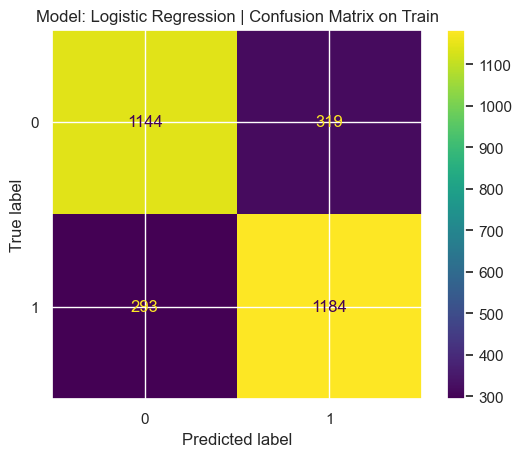

In [1174]:
confusion_matrix_heatmap(y_train, logistic_predictions_train, "Logistic Regression", "Train")

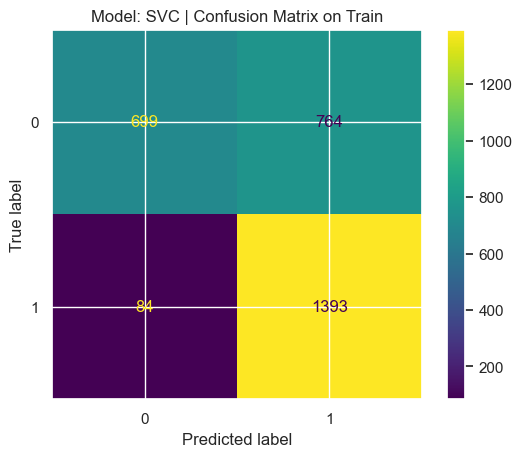

In [1141]:
confusion_matrix_heatmap(y_train, svc_predictions_train, "SVC", "Train")

#### Test

Now let's create confusion matrix for Logistic Regression.

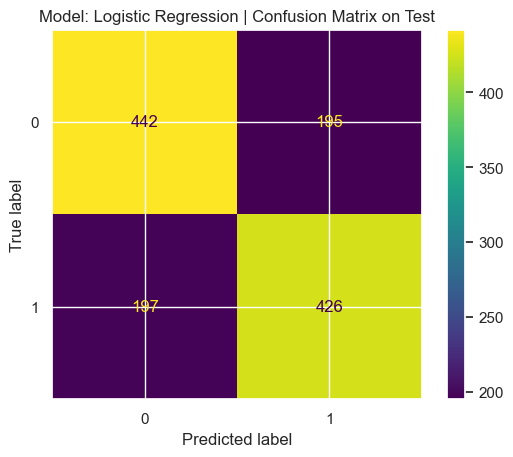

In [1175]:
confusion_matrix_heatmap(y_test, logistic_predictions_test, "Logistic Regression", "Test")

Let's create confusion matrix for for SVC.

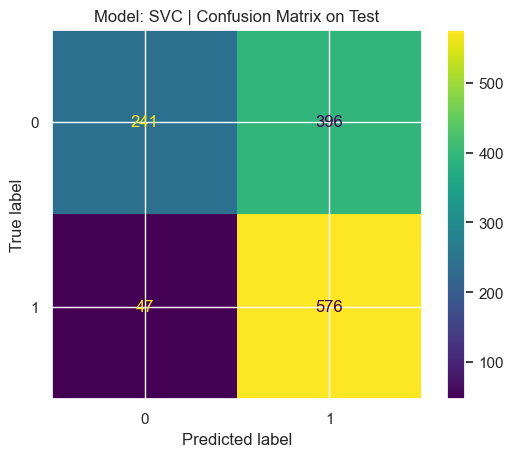

In [1143]:
confusion_matrix_heatmap(y_test, svc_predictions_test, "SVC", "Test")

Let's get classification reports

In [1231]:
logistic_report = classification_report(y_test, logistic_predictions_test, target_names=label_encoder.classes_)
svc_report = classification_report(y_test, svc_predictions_test, target_names=label_encoder.classes_)

print("Logistic Regression - Classification Report:")
print(logistic_report)

print("SVC - Classification Report:")
print(svc_report)

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

   Лермонтов       0.69      0.69      0.69       637
    Тургенев       0.69      0.68      0.68       623

    accuracy                           0.69      1260
   macro avg       0.69      0.69      0.69      1260
weighted avg       0.69      0.69      0.69      1260

SVC - Classification Report:
              precision    recall  f1-score   support

   Лермонтов       0.84      0.38      0.52       637
    Тургенев       0.59      0.92      0.72       623

    accuracy                           0.65      1260
   macro avg       0.71      0.65      0.62      1260
weighted avg       0.72      0.65      0.62      1260



#### Conclusion
My **Logit model** performs better than the **linear SVC model**.
It turned out that **SVC** performs poorly in identifying *0 author*. 
The **Logit** model shows good results in identifying authors, which is pleasing.

#### Logistic Regression
Both classes have relatively balanced precision, recall, and F1-score values.
The model performs similarly well for both classes, with an F1-score around 0.69.

The overall accuracy of the Logistic Regression model is 0.69, that's good.

#### SVC

The precision for Лермонтов is higher (84%) than for Тургенев (59%).
Тургенев has a higher recall (92%) than Лермонтов (38%), indicating that the SVC is better at capturing instances of Тургенев.
                                       
The overall accuracy of the SVC model is 0.65

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

Let's import roc_curve

In [1036]:
from sklearn.metrics import roc_curve

Let's create function to plot ROC curve with threshold

In [1236]:
def get_thershold(fpr: list(), thresholds: list(), target_fpr: float = 0.3) -> float:
    """
    Function that find threshold.
    :param fpr: false positive rate.
    :param thresholds: thresholds from roc_curve.
    :param target_fpr: target false positive rate.
    :return: threshold. 
    """
    for i in range(len(thresholds)):
        if (fpr[i] >= target_fpr):
            break
        ans = i
    return thresholds[ans]

In [1210]:
def plot_roc_with_threshold(model_name: str, fpr: list(), tpr: list(), thresholds: list(), target_fpr: float = 0.3) -> None:
    """
    Function that plot ROC curve with threshold.
    :param model_name: name of model.
    :param fpr: false positive rate.
    :param tpr: true positive rate.
    :param thresholds: thresholds from roc_curve.
    :param target_fpr: target false positive rate.
    :return: None. 
    """
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve of {model_name}")
    plt.title(f"Model: {model_name} | ROC Curve")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")

    plt.scatter(target_fpr, np.interp(target_fpr, fpr, tpr), marker='o', color='green', label=f'Target threshold (False positive rate = {target_fpr})')

    plt.legend()
    plt.show()

Okay, let's see what we have about Logistic Regression

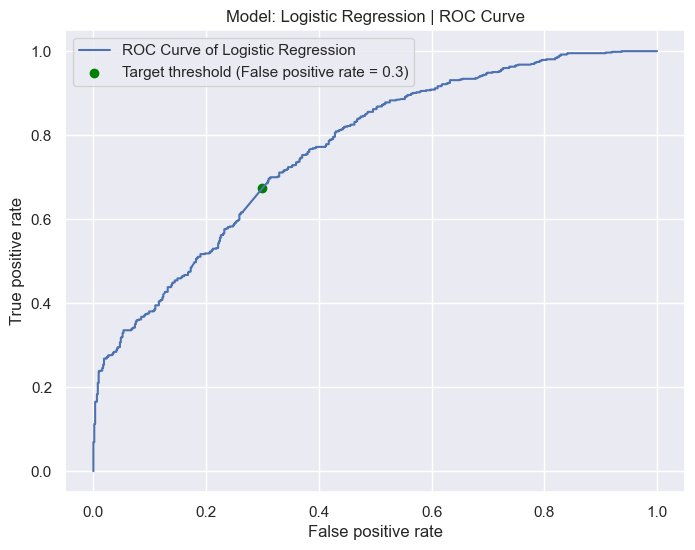

ROC AUC: 0.7662938987176546


In [1211]:
logistic_probs = logistic_grid.predict_proba(X_test)[:]
logistic_fpr, logistic_tpr, logistic_thresholds = roc_curve(y_test, logistic_probs)
logistic_roc_auc = roc_auc_score(y_test, logistic_probs)

plot_roc_with_threshold('Logistic Regression', logistic_fpr, logistic_tpr, logistic_thresholds)
print(f'ROC AUC: {logistic_roc_auc}')

Let's see what we have about Logistic Regression

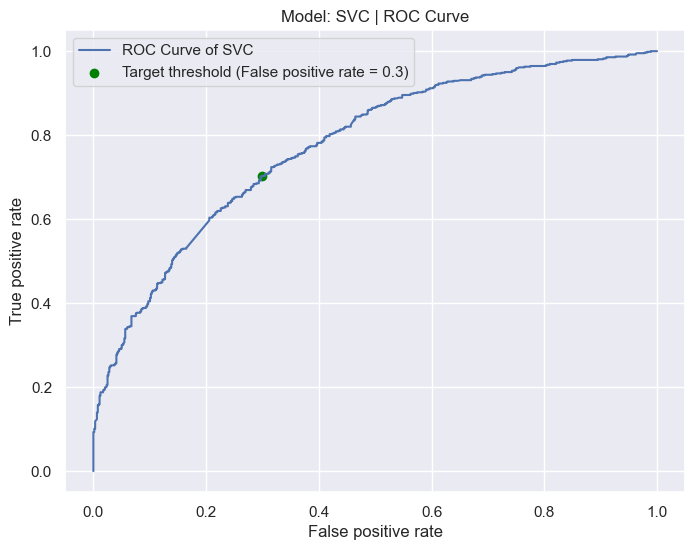

ROC AUC: 0.7751964843228315


In [1212]:
svc_probs = svc_grid.decision_function(X_test)
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_test, svc_probs)
svc_roc_auc = roc_auc_score(y_test, svc_probs)

plot_roc_with_threshold('SVC', svc_fpr, svc_tpr, svc_thresholds)
print(f'ROC AUC: {svc_roc_auc}')

Let's choice theshold by using function.

In [1237]:
print(f"Thershold: {max(get_thershold(logistic_fpr, logistic_thresholds), get_thershold(svc_fpr, svc_thresholds))}")

Thershold: 0.5000090753789301


### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

Now we need to import classifier:

In [1195]:
from sklearn.multiclass import OneVsOneClassifier

Let's create multiclass dataset.

In [1068]:
multiclass_dataset = dataset_tfidf

label_encoder_multiclass = LabelEncoder()
multiclass_dataset['author_label'] = label_encoder_multiclass.fit_transform(multiclass_dataset['author'])

In [1069]:
multiclass_dataset

,азамат,ал,александрович,алеш,ан,аркад,ах,баб,бабушк,базар,...,щек,эк,эт,яв,явля,язык,ярк,ясн,author,author_label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Блок,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Блок,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Блок,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Блок,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Блок,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев,5
8676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев,5
8677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев,5
8678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Тургенев,5


Now we need to split dataset for train and test sets.

In [1070]:
X = multiclass_dataset.drop(['author', 'author_label'], axis=1)
y = multiclass_dataset['author_label']

# Divide the data into train and test samples
X_multiclass_train, X_multiclass_test, y_multiclass_train, y_multiclass_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

### OneVsOneClassifier

Let's use grid search.

In [1214]:
logistic_model_multiclass = OneVsOneClassifier(GridSearchCV(Logit(), logit_params, cv=5, scoring='f1_micro', n_jobs=-1), n_jobs=-1)
logistic_model_multiclass.fit(X_multiclass_train, y_multiclass_train)

OneVsOneClassifier(estimator=GridSearchCV(cv=5, estimator=Logit(), n_jobs=-1,
                                          param_grid={'beta': [0, 0.001, 0.01,
                                                               1],
                                                      'gamma': [1, 0.001, 0.01],
                                                      'lr': [0.001, 0.01]},
                                          scoring='f1_micro'),
                   n_jobs=-1)

Let's get predictions:

In [1215]:
logistic_predictions_multiclass_train = logistic_grid_multiclass.predict(X_multiclass_train)
logistic_predictions_multiclass = logistic_grid_multiclass.predict(X_multiclass_test)

In [1225]:
for estimate in logistic_model_multiclass.estimators_:
    print(f"{estimate}\nBest params: {estimate.best_params_}")

GridSearchCV(cv=5, estimator=Logit(), n_jobs=-1,
             param_grid={'beta': [0, 0.001, 0.01, 1], 'gamma': [1, 0.001, 0.01],
                         'lr': [0.001, 0.01]},
             scoring='f1_micro')
Best params: {'beta': 0, 'gamma': 1, 'lr': 0.001}
GridSearchCV(cv=5, estimator=Logit(), n_jobs=-1,
             param_grid={'beta': [0, 0.001, 0.01, 1], 'gamma': [1, 0.001, 0.01],
                         'lr': [0.001, 0.01]},
             scoring='f1_micro')
Best params: {'beta': 0, 'gamma': 1, 'lr': 0.001}
GridSearchCV(cv=5, estimator=Logit(), n_jobs=-1,
             param_grid={'beta': [0, 0.001, 0.01, 1], 'gamma': [1, 0.001, 0.01],
                         'lr': [0.001, 0.01]},
             scoring='f1_micro')
Best params: {'beta': 0, 'gamma': 1, 'lr': 0.001}
GridSearchCV(cv=5, estimator=Logit(), n_jobs=-1,
             param_grid={'beta': [0, 0.001, 0.01, 1], 'gamma': [1, 0.001, 0.01],
                         'lr': [0.001, 0.01]},
             scoring='f1_micro')
Best param

### Train

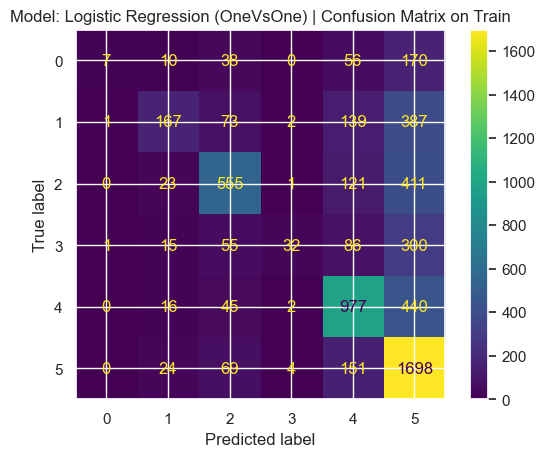

In [1226]:
confusion_matrix_heatmap(y_multiclass_train, logistic_predictions_multiclass_train, "Logistic Regression (OneVsOne)", "Train")

### Test

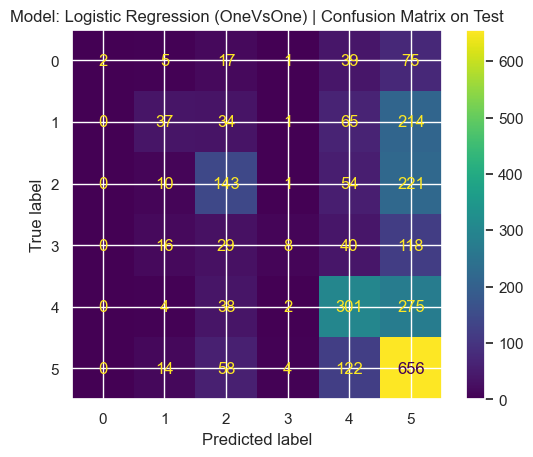

In [1227]:
confusion_matrix_heatmap(y_multiclass_test, logistic_predictions_multiclass, "Logistic Regression (OneVsOne)", "Test")

### Report

In [1233]:
logistic_report_multiclass = classification_report(y_multiclass_test, logistic_predictions_multiclass, target_names=label_encoder_multiclass.classes_)
print("Model: Logistic Regression (OneVsOne) | Classification Report")
print(logistic_report_multiclass)

Model: Logistic Regression (OneVsOne) | Classification Report
              precision    recall  f1-score   support

        Блок       1.00      0.01      0.03       139
      Гоголь       0.43      0.11      0.17       351
     Горький       0.45      0.33      0.38       429
 Достоевский       0.47      0.04      0.07       211
   Лермонтов       0.48      0.49      0.49       620
    Тургенев       0.42      0.77      0.54       854

    accuracy                           0.44      2604
   macro avg       0.54      0.29      0.28      2604
weighted avg       0.48      0.44      0.39      2604



Let's find F1 Score for the test set

In [1229]:
f1_score_multiclass = f1_score(y_multiclass_test, logistic_predictions_multiclass, average='micro')
print(f"F1 Score for Logistic Regression (OneVsOne): {f1_score_multiclass}")

F1 Score for Logistic Regression (OneVsOne): 0.44047619047619047


### Conclusion

The **Logistic Regression (OneVsOne)** has high precision for the classes.

**Logistic Regression (OneVsOne) model** has low recall for most classes, indicating that it misses a significant number of instances.
Notably, the recall for Блок (1%) and Достоевский (4%) is very low!

The F1-scores for most classes are low, indicating a trade-off between precision and recall. 
The highest F1-score is observed for Лермонтов.

Тургенев has the highest support (854), followed by Лермонтов (620).

The overall accuracy is 44%, indicating that the model c some classes of the instances.